# load annotations

In [1]:
## general functions
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from collections import OrderedDict
# visualization
from PIL import Image
# identifying faces
%pip install mtcnn
from mtcnn.mtcnn import MTCNN
# visualizing bounding boxes
import matplotlib.patches as patches
# CNN
import keras
from sklearn.model_selection import train_test_split
# Moving files between directories
import shutil
from shutil import unpack_archive
from subprocess import check_output



[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import cv2

annotations_file = 'data/WIDERFace/wider_face_split/wider_face_train_bbx_gt.txt'
df = pd.read_csv(annotations_file, sep=' ', header=None)

for index, row in df.iterrows():
    image_path = row[0]
    num_faces = int(row[1])
    bboxes = row[2:6].values.reshape(-1, 4)
    ground_truth = row[6]
    image = cv2.imread(image_path)
    
    for bbox in bboxes:
        x, y, w, h = bbox
        # do something with the image and bounding box


# preprocess annotations and images

In [4]:
import numpy as np
import pandas as pd
import cv2


In [5]:
def load_annotations(path):
    df = pd.read_csv(path, sep=' ', header=None)
    df.columns = ['filename', 'num_faces', 'x', 'y', 'w', 'h', 'ground_truth']
    return df


In [6]:
def load_images_and_annotations(image_paths, annotations):
    images = []
    bboxes = []
    for path in image_paths:
        img = cv2.imread(path)
        filename = path.split('/')[-1]
        annotation = annotations.loc[annotations['filename'] == filename]
        for index, row in annotation.iterrows():
            bbox = (int(row['x']), int(row['y']), int(row['w']), int(row['h']))
            crop = img[bbox[1]:bbox[1]+bbox[3], bbox[0]:bbox[0]+bbox[2]]
            images.append(crop)
            bboxes.append(bbox)
    return np.array(images), np.array(bboxes)


In [7]:
def preprocess_images(images, size):
    processed_images = []
    for img in images:
        img = cv2.resize(img, size)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img = np.expand_dims(img, axis=-1)
        processed_images.append(img)
    return np.array(processed_images)


In [8]:
train_annotations = load_annotations('data/WIDERFace/wider_face_split/wider_face_train_bbx_gt.txt')
train_image_paths = [filename for filename in train_annotations['filename'].unique()]
train_images, train_bboxes = load_images_and_annotations(train_image_paths, train_annotations)
train_images = preprocess_images(train_images, (300, 300))

##test_annotations = load_annotations('data/WIDERFace/wider_face_split/wider_face_test_filelist.txt')
##test_image_paths = ['data/WIDERFace/WIDER_test/images/' + filename for filename in test_annotations['filename'].unique()]
##test_images, test_bboxes = load_images_and_annotations(test_image_paths, test_annotations)
##test_images = preprocess_images(test_images, (300, 300))

val_annotations = load_annotations('data/WIDERFace/wider_face_split/wider_face_val_bbx_gt.txt')
val_image_paths = [filename for filename in val_annotations['filename'].unique()]
val_images, val_bboxes = load_images_and_annotations(val_image_paths, val_annotations)
val_images = preprocess_images(val_images, (300, 300))


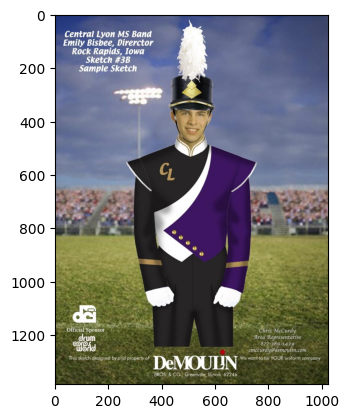

In [9]:
im = Image.open(str(train_image_paths[0]))
plt.imshow(im)

1/1 [==============================] - 0s 161ms/step


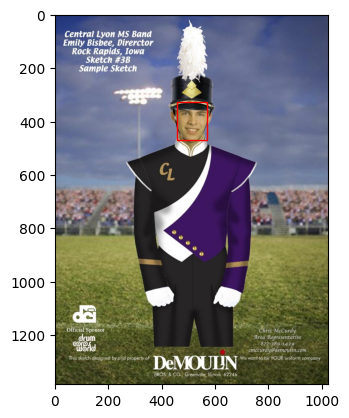

In [10]:
# Use out-of-the-box MTCNN algorithm to identify facial boundaries on a sample image
detector = MTCNN()
image = cv2.imread(str(train_image_paths[0]))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
result = detector.detect_faces(image)
# That's it - the results have already been generated! Now we extract the boundaries that have been identified 
bounding_box = result[0]['box']
keypoints = result[0]['keypoints']

# Finally, we plot the image along with the face's bounding box and internal features (eyes, nose, and mouth corners)
fig,ax = plt.subplots(1)
ax.imshow(image)
# Create a Rectangle patch
rect = patches.Rectangle(bounding_box[0:2],bounding_box[2],bounding_box[3],linewidth=1,edgecolor='r',facecolor='none')
# Add the patch to the Axes
ax.add_patch(rect)
# Visualize all the internal features
#for key in keypoints:
    #rect_key = patches.Rectangle(keypoints[key],1,1,linewidth=10,edgecolor='r',facecolor='none')
    #ax.add_patch(rect_key)
# Show the plots
plt.show()

In [12]:
import os
import csv

DATA_DIR = "data/WIDERFace"

# Define the paths to the image and annotation directories
image_dir = os.path.join(DATA_DIR, "WIDER_train/images")
anno_dir = os.path.join(DATA_DIR, "wider_face_split/wider_face_train_bbx_gt.txt")

# Open the CSV file for writing
with open("widerface_train.csv", "w") as csvfile:
    writer = csv.writer(csvfile)

    # Loop over each line in the annotation file
    with open(anno_dir, "r") as f:
        for line in f:
            if line.startswith("#"):
                # Skip the comment lines
                continue

            # Extract the image filename and bounding box coordinates
            parts = line.strip().split(" ")
            filename = os.path.join(image_dir, parts[0])
            x1, y1, w, h = map(int, parts[2:6])
            x2, y2 = x1 + w, y1 + h

            # Write the image path and bounding box coordinates to the CSV file
            writer.writerow([filename, x1, y1, x2, y2, "face"])


In [13]:
import os
import cv2
import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset


class WiderFaceDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        img_path = self.annotations.iloc[idx, 0]
        bbox = self.annotations.iloc[idx, 1:5].values
        label = self.annotations.iloc[idx, 5]

        # Load the image and convert to RGB
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Convert the bounding box coordinates to PyTorch format
        bbox = bbox.astype(np.float32)
        bbox = torch.tensor(bbox)

        # Apply the transforms, if any
        if self.transform:
            img, bbox = self.transform(img, bbox)

        return img, bbox, label


In [14]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Reshape


In [ ]:
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117

Looking in indexes: https://download.pytorch.org/whl/cu117Note: you may need to restart the kernel to use updated packages.

     ---------------------------------------- 0.0/2.3 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.3 GB 6.3 MB/s eta 0:06:14
     ---------------------------------------- 0.0/2.3 GB 6.7 MB/s eta 0:05:50
     ---------------------------------------- 0.0/2.3 GB 7.2 MB/s eta 0:05:25
     ---------------------------------------- 0.0/2.3 GB 7.8 MB/s eta 0:05:01
     ---------------------------------------- 0.0/2.3 GB 8.1 MB/s eta 0:04:50
     ---------------------------------------- 0.0/2.3 GB 8.3 MB/s eta 0:04:41
     ---------------------------------------- 0.0/2.3 GB 8.5 MB/s eta 0:04:36
     ---------------------------------------- 0.0/2.3 GB 8.6 MB/s eta 0:04:33
     ---------------------------------------- 0.0/2.3 GB 8.6 MB/s eta 0:04:32
     ---------------------------------------- 0.0/2.3 GB 8.7 MB/s eta 0:04:30
     -------------------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
import torch.nn as nn
import torch.nn.functional as F

class SSD(nn.Module):
    def __init__(self, num_classes):
        super(SSD, self).__init__()
        
        # Define the base VGG16 network
        self.base = nn.ModuleList([
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(512, 1024, kernel_size=3, padding=6, dilation=6),
            nn.ReLU(inplace=True),
            nn.Conv2d(1024, 1024, kernel_size=1),
            nn.ReLU(inplace=True)
        ])
        
        # Define the auxiliary convolutional layers
        self.aux_convs = nn.ModuleList([
            nn.Conv2d(512, 256, kernel_size=1),
            nn.Conv2d(256, 512, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(512, 128, kernel_size=1),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(128, 256, kernel_size=3),
            nn.Conv2d(256, 128, kernel_size=1),
            nn.Conv2d(128, 256, kernel_size=3)
        ])
        
        # Define the localization and classification layers
        self.loc_layers = nn.ModuleList([
            nn.Conv2d(512, 4 * 4, kernel_size=3, padding=1),
            nn.Conv2d(1024, 6 * 4, kernel_size=3, padding=1),
            nn.Conv2d(512, 6 * 4, kernel_size=3, padding=1),
            nn.Conv2d(256, 6 * 4, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=0),
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=0),
            nn.Conv2d(256, 4 * 4, kernel_size=3, padding=0)
        ])
        
        self.cls_layers = nn.ModuleList([
            nn.Conv2d(512, 4 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(1024, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(512, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 6 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=1),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=0),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=0),
            nn.Conv2d(256, 4 * num_classes, kernel_size=3, padding=0)
        ])



In [16]:
import torch
import torchvision.transforms as transforms

# Create an instance of the SSD class
ssd = SSD(num_classes=2)

# Load some input data
input_data = torch.randn(1, 3, 300, 300)

# Define a transformation to apply to the input data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Apply the transformation to the input data
input_data = transform(input_data)

# Make a prediction using the SSD model
output = ssd(input_data)

# Print the output shape
print(output.shape)


TypeError: pic should be PIL Image or ndarray. Got <class 'torch.Tensor'>

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define hyperparameters
num_epochs = 10
batch_size = 32
learning_rate = 0.001

# Initialize SSD model and optimizer
model = SSD(num_classes=2)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Define loss function
criterion = nn.MultiBoxLoss()

# Load custom dataset
dataset = CustomDataset(dataset_path='/path/to/custom/dataset')
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Train the SSD model
for epoch in range(num_epochs):
    for images, targets in data_loader:
        
        # Forward pass
        predicted_locs, predicted_scores = model(images)
        
        # Compute loss
        loss = criterion(predicted_locs, predicted_scores, targets)
        
        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # Print loss after every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


ModuleNotFoundError: No module named 'custom_dataset'

In [ ]:
# Load the trained model
model = load_model('my_trained_model.h5')

# Load the validation dataset annotations
val_annotations = load_annotations('wider_face_val_annotations.txt')

# Create a WIDER Face validation dataset object
val_dataset = WIDERFaceDataset('path/to/wider_face_val/images', val_annotations)

# Define the batch size and number of batches
batch_size = 32
num_batches = len(val_dataset) // batch_size

# Initialize variables for storing predictions and ground truth labels
all_predictions = []
all_labels = []

# Loop over the validation dataset in batches
for i in range(num_batches):
    # Get a batch of images and labels
    images, labels = val_dataset.get_batch(i, batch_size)
    
    # Make predictions on the batch of images
    predictions = model.predict(images)
    
    # Append the predictions and labels to the all_predictions and all_labels lists
    all_predictions.append(predictions)
    all_labels.append(labels)

# Concatenate the predictions and labels from all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

# Compute the mean Average Precision (mAP) metric
mAP = compute_mAP(all_predictions, all_labels)

# Print the mAP score
print('mAP: {:.4f}'.format(mAP))


In [ ]:
import matplotlib.pyplot as plt

history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10)

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
